In [2]:
import pymc as pm
import formulaic
import pandas as pd
import numpy as np

data = pd.read_csv("../../single_parameter/combined_data/statistics.csv")

model_formula = 'Coverage ~ 0 + C(TargetModule) + C(TuningParameters, Treatment(reference="NONE"))'
model_spec = formulaic.model_matrix(model_formula, data=data)
model_spec.rhs.iloc[:, 24:]

,"C(TuningParameters, Treatment(reference='NONE'))[T.ChangeParameterProbability]","C(TuningParameters, Treatment(reference='NONE'))[T.ChromosomeLength]","C(TuningParameters, Treatment(reference='NONE'))[T.CrossoverRate]","C(TuningParameters, Treatment(reference='NONE'))[T.Elite]","C(TuningParameters, Treatment(reference='NONE'))[T.Population]","C(TuningParameters, Treatment(reference='NONE'))[T.RandomPerturbation]","C(TuningParameters, Treatment(reference='NONE'))[T.StatementInsertionProbability]","C(TuningParameters, Treatment(reference='NONE'))[T.TestChangeProbability]","C(TuningParameters, Treatment(reference='NONE'))[T.TestDeleteProbability]","C(TuningParameters, Treatment(reference='NONE'))[T.TestInsertProbability]","C(TuningParameters, Treatment(reference='NONE'))[T.TestInsertionProbability]","C(TuningParameters, Treatment(reference='NONE'))[T.TournamentSize]"
0,0,0,0,0,0,0,0,1,0,0,0,0
1,0,0,0,1,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,1,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,1,0,0
4,0,1,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
9355,0,0,0,0,1,0,0,0,0,0,0,0
9356,0,0,0,0,1,0,0,0,0,0,0,0
9357,0,0,0,0,0,1,0,0,0,0,0,0
9358,0,1,0,0,0,0,0,0,0,0,0,0


In [1]:
import pymc as pm

with pm.Model() as model:
    # Global Intercept and standard deviation for Modules
    a_bar = pm.Normal('a_bar', mu=0, sigma=1.0)
    sigma_a = pm.Exponential('sigma_a', 1.0)
    
    # Module specific intercept
    a_m = pm.Normal('a_m', mu=a_bar, sigma=sigma_a, shape=24)

    # Global parameter standard deviation
    sigma_b = pm.Exponential("sigma_b", 2.0)

    # Parameter effects
    b_p = pm.Normal('b_p', mu=0, sigma=sigma_b, shape= 12)
    
    # Activate the correct module dummy variable
    logit_a = pm.math.dot(model_spec.rhs.iloc[:, :24], a_m)
    logit_b = pm.math.dot(model_spec.rhs.iloc[:, 24:], b_p)

    # Link function (logit), unbounded to (0,1) probability
    p = pm.Deterministic('p', pm.math.invlogit(logit_a + logit_b))
    
    # Beta distribution likelihood 
    theta = pm.Uniform('theta', 20, 200) # Disperion parameter
    Y_obs = pm.Beta('Y_obs', alpha=p*theta, beta=(1-p)*theta, observed=model_spec.lhs['Coverage'])
    
    # Sample from the model and compute log likelihood (for information criterion)
    trace = pm.sample(100, chains=4, return_inferencedata=True, progressbar=True, target_accept = 0.95)
    log_lik = pm.compute_log_likelihood(trace)

print("Model building complete.")

NameError: name 'model_spec' is not defined

In [ ]:
import arviz as az

def logit_to_probability(logit_vals):
    """Apply logistic transformation to logit values."""
    return 1 / (1 + np.exp(-logit_vals))


def log_odds_to_or(log_odds):
    return np.exp(log_odds)

# Create a dictionary for the posterior
posterior_dict = {
    'a_m': trace.posterior['a_m'].values,
    'a_bar': trace.posterior['a_bar'].values,
    'sigma_a': trace.posterior['sigma_a'].values
    
}

for key, value in posterior_dict.items():
    posterior_dict[key] = logit_to_probability(value)


posterior_dict['theta'] = trace.posterior['theta'].values
posterior_dict['sigma_b'] = trace.posterior['sigma_b'].values
posterior_dict['b_p'] = trace.posterior['b_p'].values #log_odds_to_or(trace.posterior['beta_p'].values)

# Create an InferenceData object
infdata = az.from_dict(posterior=posterior_dict)

# Generate a summary table with the mean and 89% HDI for all variables
summary = az.summary(infdata, hdi_prob=0.89)
summary

,mean,sd,hdi_5.5%,hdi_94.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
a_m[0],0.873,0.003,0.870,0.878,0.000,0.000,3062.0,1582.0,1.0
a_m[1],0.663,0.004,0.656,0.668,0.000,0.000,2284.0,908.0,1.0
a_m[2],0.933,0.002,0.930,0.936,0.000,0.000,3728.0,2613.0,1.0
a_m[3],0.052,0.002,0.049,0.054,0.000,0.000,3725.0,1318.0,1.0
a_m[4],0.077,0.002,0.073,0.080,0.000,0.000,4032.0,2535.0,1.0
a_m[5],0.598,0.004,0.591,0.604,0.000,0.000,3342.0,2819.0,1.0
a_m[6],0.747,0.004,0.742,0.753,0.000,0.000,3070.0,3081.0,1.0
a_m[7],0.793,0.003,0.788,0.798,0.000,0.000,4500.0,3019.0,1.0
a_m[8],0.279,0.004,0.273,0.284,0.000,0.000,3293.0,2707.0,1.0
a_m[9],0.140,0.003,0.136,0.144,0.000,0.000,4892.0,2910.0,1.0


array([[<Axes: title={'center': 'a_m'}>, <Axes: title={'center': 'a_m'}>],
       [<Axes: title={'center': 'b_p'}>, <Axes: title={'center': 'b_p'}>],
       [<Axes: title={'center': 'sigma_b'}>,
        <Axes: title={'center': 'sigma_b'}>]], dtype=object)

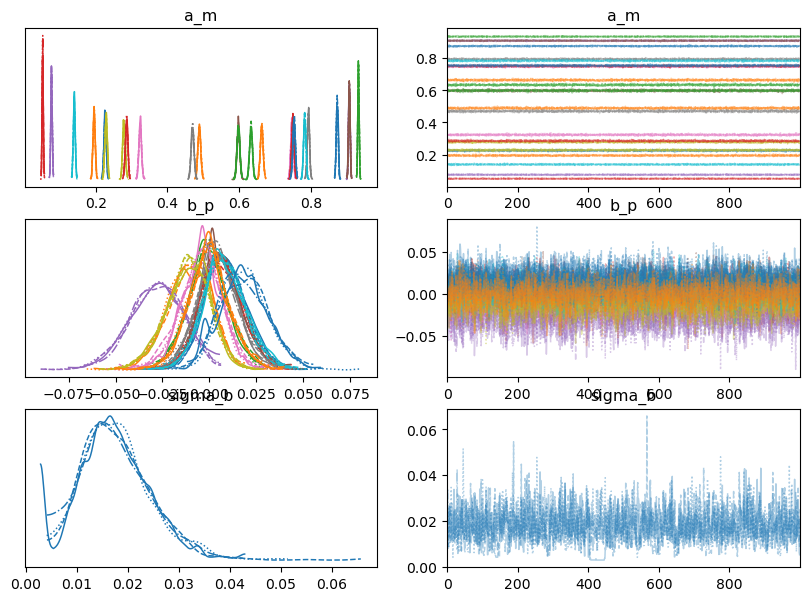

In [52]:
az.plot_trace(posterior_dict, var_names=['a_m', 'b_p', 'sigma_b'], figsize=(10, 7))

In [32]:
import arviz as az

az.to_netcdf(trace, "model_2_trace.nc")

'model_2_trace.nc'

In [33]:
az.loo(az.from_netcdf("model_2_trace.nc"))

Computed from 4000 posterior samples and 9360 observations log-likelihood matrix.

         Estimate       SE
elpd_loo 13378.08   233.39
p_loo       46.39        -
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.5]   (good)     9360  100.0%
 (0.5, 0.7]   (ok)          0    0.0%
   (0.7, 1]   (bad)         0    0.0%
   (1, Inf)   (very bad)    0    0.0%

Sampling: [a_bar, a_m, b_p, sigma_a, sigma_b, theta]


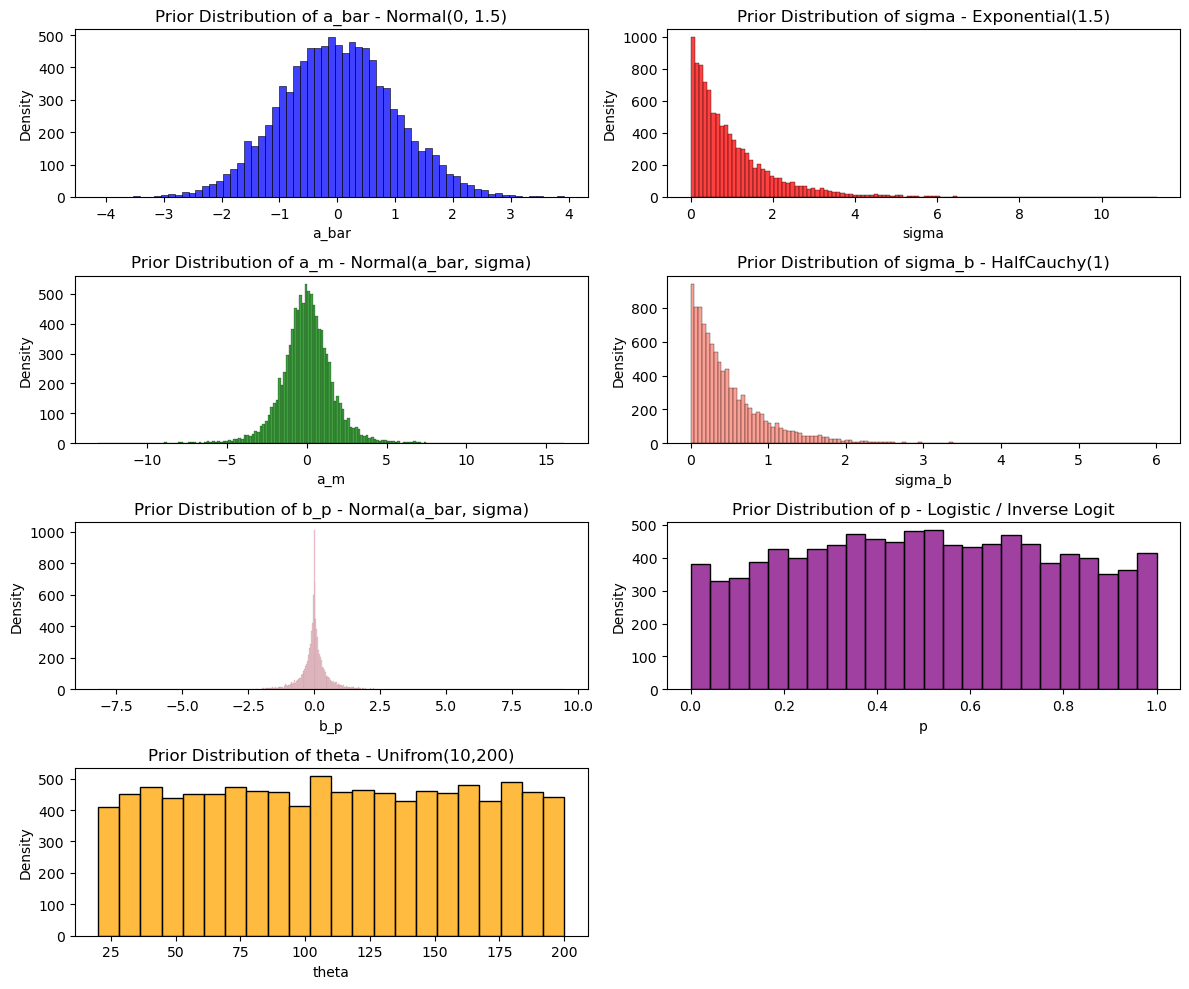

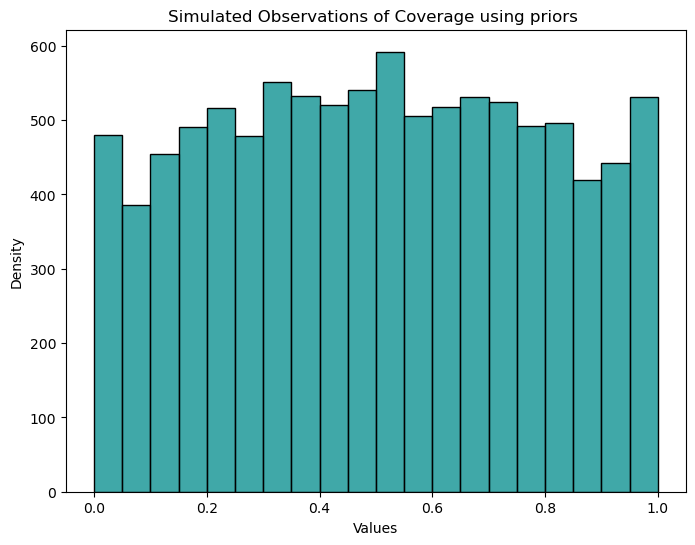

In [66]:
import pymc as pm
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

with pm.Model() as model:
    # Global Intercept and standard deviation for Modules
    a_bar = pm.Normal('a_bar', mu=0, sigma=1.0)
    sigma_a = pm.Exponential('sigma_a', 1.0)
    
    # Module specific intercept
    a_m = pm.Normal('a_m', mu=a_bar, sigma=sigma_a)

    # Global parameter standard deviation
    sigma_b = pm.Exponential('sigma_b', 2.0)

    # Parameter effects
    b_p = pm.Normal('b_p', mu=0, sigma=sigma_b)

    # Link function (logit), unbounded to (0,1) probability
    p = pm.Deterministic('p', pm.math.invlogit(a_m + b_p))
    
    # Beta distribution likelihood 
    theta = pm.Uniform('theta', 20, 200) # Disperion parameter
    
    # Sample Priors
    idata = pm.sample_prior_predictive(samples=10000)


# Fetch and flatten priors
prior_a_bar = idata.prior['a_bar'].values.flatten()
prior_sigma_a = idata.prior['sigma_a'].values.flatten()
prior_a_m = idata.prior['a_m'].values.flatten()
prior_sigma_b = idata.prior['sigma_b'].values.flatten()
prior_b_p = idata.prior['b_p'].values.flatten()
prior_p = idata.prior['p'].values.flatten()
prior_theta = idata.prior['theta'].values.flatten()


# Sample one data point from each combination of priors
simulated_observations = np.random.beta(a=prior_p * prior_theta, b=(1 - prior_p) * prior_theta)

plt.figure(figsize=(12, 10))

# a_bar
plt.subplot(4, 2, 1)
sns.histplot(prior_a_bar, color='blue')
plt.title('Prior Distribution of a_bar - Normal(0, 1.5)')
plt.xlabel('a_bar')
plt.ylabel('Density')

# sigma
plt.subplot(4, 2, 2)
sns.histplot(prior_sigma_a, color='red')
plt.title('Prior Distribution of sigma - Exponential(1.5)')
plt.xlabel('sigma')
plt.ylabel('Density')

# a_m
plt.subplot(4, 2, 3)
sns.histplot(prior_a_m, color='green')
plt.title('Prior Distribution of a_m - Normal(a_bar, sigma)')
plt.xlabel('a_m')
plt.ylabel('Density')

# b_p
plt.subplot(4, 2, 4)
sns.histplot(prior_sigma_b, color='salmon')
plt.title('Prior Distribution of sigma_b - HalfCauchy(1)')
plt.xlabel('sigma_b')
plt.ylabel('Density')

# b_p
plt.subplot(4, 2, 5)
sns.histplot(prior_b_p, color='pink')
plt.title('Prior Distribution of b_p - Normal(a_bar, sigma)')
plt.xlabel('b_p')
plt.ylabel('Density')

# p
plt.subplot(4, 2, 6)
sns.histplot(prior_p, color='purple')
plt.title('Prior Distribution of p - Logistic / Inverse Logit')
plt.xlabel('p')
plt.ylabel('Density')

# theta
plt.subplot(4, 2, 7)
sns.histplot(prior_theta, color='orange')
plt.title('Prior Distribution of theta - Unifrom(10,200)')
plt.xlabel('theta')
plt.ylabel('Density')

plt.tight_layout()
plt.show()

# Predicated observations
plt.figure(figsize=(8, 6))
sns.histplot(simulated_observations, bins=np.arange(0, 1.05, 0.05), color='darkcyan')
plt.title('Simulated Observations of Coverage using priors ')
plt.xlabel('Values')
plt.ylabel('Density')
plt.show()

